In [75]:
# Modules import
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    plot_confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from numpy.random import RandomState

In [76]:
# Supressão de warnings
import warnings

warnings.filterwarnings("ignore")

In [77]:
# Aumenta o número de linhas para visualização
pd.set_option('display.max_rows', 200)

In [78]:
RANDOM_NUM = 42
np.random.seed(42)
RANDOM_STATE = RandomState(42)

In [79]:
df = pd.read_csv("weight_lifting.csv", header=1)
df.to_csv(r'outputs/original_database.csv', quoting=csv.QUOTE_NONNUMERIC)
df.head()

,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,...,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,classe
0,eurico,1322489729,34670,28/11/2011 14:15,no,1,3.70,41.6,-82.8,3,...,-0.05,-0.37,-0.43,-170,155,184,-1160,1400,-876,E
1,eurico,1322489729,62641,28/11/2011 14:15,no,1,3.66,42.8,-82.5,2,...,-0.06,-0.37,-0.59,-178,164,182,-1150,1410,-871,E
2,eurico,1322489729,70653,28/11/2011 14:15,no,1,3.58,43.7,-82.3,1,...,-0.05,-0.27,-0.72,-182,172,185,-1130,1400,-863,E
3,eurico,1322489729,82654,28/11/2011 14:15,no,1,3.56,44.4,-82.1,1,...,0.02,-0.24,-0.79,-185,182,188,-1120,1400,-855,E
4,eurico,1322489729,90637,28/11/2011 14:15,no,1,3.57,45.1,-81.9,1,...,0.08,-0.27,-0.82,-188,195,188,-1100,1400,-843,E


### Limpeza mínima da base de dados

In [80]:
df.drop(columns=["user_name", "raw_timestamp_part_1", "raw_timestamp_part_2", "cvtd_timestamp", "new_window", "num_window"], inplace=True)
# df.dtypes

In [81]:
# Corrigindo campos com "#DIV/0!"
for col in df.columns:
    if df[col].dtype == object and col != "classe":
        df[col] = df[col].str.replace("#DIV/0!", "0")
        df[col] = df[col].astype(float)
# df.dtypes

In [82]:
# Corrigindo valores N/A com a média
df.fillna(df.mean(), inplace=True)

In [83]:
df.to_csv(r'outputs/cleaned_database.csv', quoting=csv.QUOTE_NONNUMERIC)

### Divisão entre base de treino e teste

In [84]:
# Datasets
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,)


### Descobrir os melhores parâmetros para os classificadores

In [71]:
models_base = [
    {
        "name": "LR",
        "classifier": LogisticRegression(),
        "parameters": [
            {
                "penalty": ["l2"],
                "solver": ["newton-cg", "sag", "lbfgs", "liblinear"],
                "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                "fit_intercept": [True, False],
                "multi_class": ["auto", "ovr"],
            },
            {
                "penalty": ["elasticnet"],
                "solver": ["saga"],
                "C": [0.001],
                "fit_intercept": [True, False],
                "multi_class": ["auto", "ovr", "multinomial"],
                "l1_ratio": [0, 0.5, 1],
            },
        ],
    },
    {
        "name": "SVM",
        "classifier": SVC(),
        "parameters": [
            {
                "C": [0.1, 0.5, 1, 10, 100, 500, 1000],
                "gamma": ["scale"],
                "kernel": ["poly"],
                "probability": [True],
            },
            {
                "C": [0.1, 0.5, 1, 10, 100, 500, 1000],
                "gamma": [0.1, 0.001, 0.0001, 0.00001],
                "kernel": ["rbf"],
                "probability": [True],
            },
        ],
    },
    {
        "name": "MPL",
        "classifier": MLPClassifier(),
        "parameters": [
            {
                "solver": ["lbfgs", "sgd", "adam"],
                "alpha": [1e-4, 1e-5],
                "hidden_layer_sizes": [(5, 2), (100,)],
            }
        ],
    },
]


In [69]:
# Treinar e predizer com GridSearchCV
models_base_predict = []
for mb in models_base:
    model = GridSearchCV(mb["classifier"], mb["parameters"], n_jobs=-1, verbose=1)
    model = model.fit(X_train, np.ravel(y_train, order="C"))
    predict = model.predict(X_test)

    best_parameters = model.best_params_
    result = {
        "name": mb["name"],
        "best_score": model.best_score_,
        "best_parameters": best_parameters,
        "predict": predict,
        "model": model,
    }
    pprint(result)
    models_base_predict.append(result)


Fitting 5 folds for each of 130 candidates, totalling 650 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 650 out of 650 | elapsed:  8.3min finished


{'best_parameters': {'C': 0.01,
                     'fit_intercept': True,
                     'multi_class': 'ovr',
                     'penalty': 'l2',
                     'solver': 'newton-cg'},
 'best_score': 0.9923797129144564,
 'model': GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'fit_intercept': [True, False],
                          'multi_class': ['auto', 'ovr'], 'penalty': ['l2'],
                          'solver': ['newton-cg', 'sag', 'lbfgs', 'liblinear']},
                         {'C': [0.001], 'fit_intercept': [True, False],
                          'l1_ratio': [0, 0.5, 1],
                          'multi_class': ['auto', 'ovr', 'multinomial'],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             verbose=1),
 'name': 'LR',
 'predict': array(['E', 'E', 'A', ..., 'C', 'B', 'E'], dtype=object)}
Fitting 5 folds for each of 35 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  5.9min finished


{'best_parameters': {'C': 10,
                     'gamma': 1e-05,
                     'kernel': 'rbf',
                     'probability': True},
 'best_score': 0.9877428530636003,
 'model': GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 0.5, 1, 10, 100, 500, 1000],
                          'gamma': ['scale'], 'kernel': ['poly'],
                          'probability': [True]},
                         {'C': [0.1, 0.5, 1, 10, 100, 500, 1000],
                          'gamma': [0.1, 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf'], 'probability': [True]}],
             verbose=1),
 'name': 'SVM',
 'predict': array(['E', 'E', 'A', ..., 'C', 'B', 'E'], dtype=object)}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:   19.7s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   24.6s finished


{'best_parameters': {'alpha': 0.0001,
                     'hidden_layer_sizes': (100,),
                     'solver': 'adam'},
 'best_score': 0.9559350048872635,
 'model': GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid=[{'alpha': [0.0001, 1e-05],
                          'hidden_layer_sizes': [(5, 2), (100,)],
                          'solver': ['lbfgs', 'sgd', 'adam']}],
             verbose=1),
 'name': 'MPL',
 'predict': array(['E', 'E', 'A', ..., 'B', 'B', 'E'], dtype='<U1')}


### Treinar e predizer com os parâmetros ajustados

In [85]:
models_base = [
    ('LR', LogisticRegression(**{
        'C': 0.01,
        'fit_intercept': True,
        'multi_class': 'ovr',
        'penalty': 'l2',
        'solver': 'newton-cg'})),
    ('SVM', SVC(**{
        'C': 10,
        'gamma': 1e-05,
        'kernel': 'rbf',
        'probability': True})),
    ('MPL', MLPClassifier(**{
        'alpha': 0.0001,
        'hidden_layer_sizes': (100,),
        'solver': 'adam'}))
]
models_base_predict = []
for result in models_base:
    name, model = result
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    models_base_predict.append({
        "name": name,
        "model": model,
        "predict": predict
    })

### Avaliar predições

In [86]:

def plot_results():
    for result in models_base_predict:
        print(f"Model: {result['name']}")
        print(f"Accuracy: {round(accuracy_score(y_test, result['predict']), 4)}")
        print(f"F1: {round(f1_score(y_test, result['predict'], average='macro'), 4)}")
        print(f"Precision: {round(precision_score(y_test, result['predict'], average='macro'), 4)}")
        print(f"Recall: {round(recall_score(y_test, result['predict'], average='macro'), 4)}")
        print()
        print(confusion_matrix(y_test, result["predict"]))
        print()
        print(classification_report(y_test, result["predict"]))
        print()
        plot_confusion_matrix(model, X_test, y_test)
        plt.show()
        print("--------------------------------------------")


Model: LR
Accuracy: 0.9881
F1: 0.9829
Precision: 0.979
Recall: 0.9874

[[323   2   0   0   0]
 [  7 209   2   0   0]
 [  0   0  26   0   0]
 [  0   0   0  64   1]
 [  0   0   0   0 372]]

              precision    recall  f1-score   support

           A       0.98      0.99      0.99       325
           B       0.99      0.96      0.97       218
           C       0.93      1.00      0.96        26
           D       1.00      0.98      0.99        65
           E       1.00      1.00      1.00       372

    accuracy                           0.99      1006
   macro avg       0.98      0.99      0.98      1006
weighted avg       0.99      0.99      0.99      1006




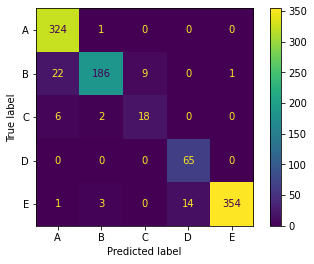

--------------------------------------------
Model: SVM
Accuracy: 0.9821
F1: 0.9731
Precision: 0.9899
Recall: 0.9582

[[320   0   0   0   5]
 [  0 211   0   0   7]
 [  0   2  23   0   1]
 [  0   0   0  62   3]
 [  0   0   0   0 372]]

              precision    recall  f1-score   support

           A       1.00      0.98      0.99       325
           B       0.99      0.97      0.98       218
           C       1.00      0.88      0.94        26
           D       1.00      0.95      0.98        65
           E       0.96      1.00      0.98       372

    accuracy                           0.98      1006
   macro avg       0.99      0.96      0.97      1006
weighted avg       0.98      0.98      0.98      1006




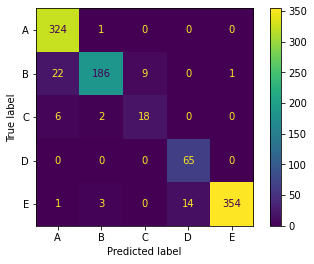

--------------------------------------------
Model: MPL
Accuracy: 0.9414
F1: 0.8838
Precision: 0.8746
Recall: 0.8988

[[324   1   0   0   0]
 [ 22 186   9   0   1]
 [  6   2  18   0   0]
 [  0   0   0  65   0]
 [  1   3   0  14 354]]

              precision    recall  f1-score   support

           A       0.92      1.00      0.96       325
           B       0.97      0.85      0.91       218
           C       0.67      0.69      0.68        26
           D       0.82      1.00      0.90        65
           E       1.00      0.95      0.97       372

    accuracy                           0.94      1006
   macro avg       0.87      0.90      0.88      1006
weighted avg       0.95      0.94      0.94      1006




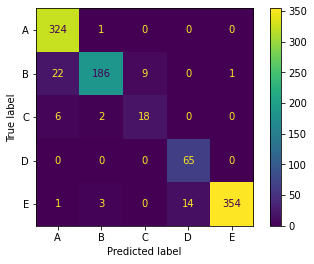

--------------------------------------------


In [87]:
plot_results()